In [481]:
from sklearn.decomposition import PCA
import numpy as np 
from numpy.linalg import svd 
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [482]:
def buggyPCA(X, d):
    U, S, Vt = svd(X, full_matrices=False, compute_uv=True)
    Vd=Vt[:d, :]
    z=np.dot(X,Vd.T)
    recon = np.dot(z, Vd)
    
    return(z, Vd, recon)


In [483]:
def deMeanedPCA(X, d):
    B = X.copy() 
    Xmean = np.mean(B, axis=0) 
    B -= Xmean 
    z, Vd, recon = buggyPCA(B, d)
    Y = recon + Xmean

    return (z,Vd, Xmean, Y)

In [484]:
def normalizedPCA(X, d):
    B = X.copy() 
    Xmean = np.mean(B, axis=0) 
    Xstd = np.std(B, axis=0)
    B = (B - Xmean)/Xstd 
    z, Vd, recon = buggyPCA(B, d)
    Y = (recon * Xstd) + Xmean
    return (z, Vd, Xmean, Xstd, Y)

In [485]:
def DRO(X,d):
    n = X.shape[0]
    B = X.copy()
    b = (np.mean(B, axis=0))
    B -= b
    Ud, Sd, Vdt = svd(B, full_matrices=True)
    
    S = np.zeros((X.shape), dtype=float)
    S[:X.shape[1], :X.shape[1]] = np.diag(Sd)
    
    Ud = Ud[:,0:d]
    S = S[0:d, 0:d]
    Vd=Vdt[:d, :]
    
    Z = np.sqrt(n) * Ud
    A = (1/np.sqrt(n) * S * Vd.T)
    J = np.multiply(Z,A.T) + b
    
    return J, A, Z, b

In [486]:
def DRLV(X, d):
    n = X.shape[0]
    D = X.shape[1]
    J, A, Z, b = DRO(X,d)
    
    eta = np.sqrt(np.mean((J-X)**2))
    
    for i in range(10):
        d = A.shape[1]
        
        #E-Step
        var_x = np.matmul(A, A.T) + eta**2 * np.identity(D)
        
        
        #mean
        Qzx_u = np.matmul(np.matmul(X-b, np.linalg.inv(var_x)), A)
        #variance
        Qzx_v = np.identity(D) - np.matmul(np.matmul(A.T, np.linalg.inv(var_x)), A)
        
        
        #M-Step

        #update A first
        Qa = np.matmul(Qzx_u, A.T)
        
        sum1 = np.matmul(((X - b).T), Qzx_u)
        sum2 = np.matmul(Qa.T, Qa) + (n * Qzx_v)
        
        A_n = np.matmul(np.linalg.inv(sum2),sum1)
        
        #update eta
        
        eta_n = np.sqrt(np.sum((1/(n*D) * (np.linalg.norm(X-b)**2 - 2 * (np.matmul((X-b).T, Qa))
                                  + np.matmul(Qa.T, Qa)))))
        
        A = A_n.copy()
        eta = eta_n
    
    # Reconstruction
    var_x = np.matmul(A, A.T) + eta**2 * np.identity(D)
    Z = np.matmul(X-b, np.matmul(np.linalg.inv(var_x), A))
    J = np.matmul(Z, A.T) + b
    
    #print(J)
        
    return J
        

# Reconstruction Error + scatter plots for each method

Note: Blue is the reconstructed data and orange is the original

BuggyPCA reconstruction error : 0.8869030837347942


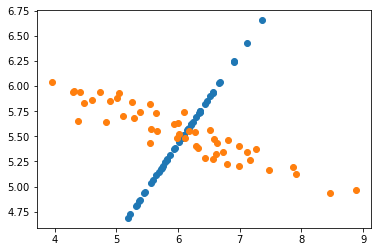

In [487]:
data = np.loadtxt(open("./data/data2D.csv", "rb"), delimiter=",") #skiprows=1)

samples,features = data.shape
#print(data.shape)
z, Vd, reconB = buggyPCA(data, 1)
rec_errB = (np.sum(np.square(data-reconB)))/samples
plt.scatter(reconB[:, 0], reconB[:, 1])
plt.scatter(data[:, 0], data[:, 1])
plt.show
print  ("BuggyPCA reconstruction error :", rec_errB)


DemeanedPCA reconstruction error : 0.010006085628512917


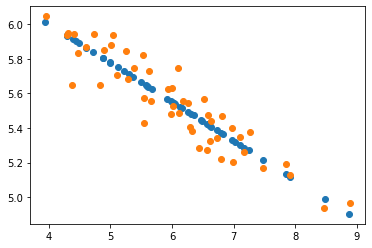

In [488]:
z, Vd, mean, reconD = deMeanedPCA(data, 1)
rec_errD = (np.sum(np.square(data-reconD)))/samples
plt.scatter(reconD[:, 0], reconD[:, 1])
plt.scatter(data[:, 0], data[:, 1])
plt.show
print  ("DemeanedPCA reconstruction error :", rec_errD)



NormalizedPCA reconstruction error : 0.049472083454770714


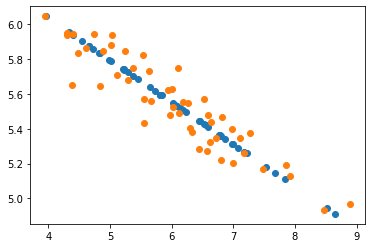

In [489]:
z, Vd, mean, std, reconN = normalizedPCA(data, 1)
rec_errN = (np.sum(np.square(data-reconN)))/samples
plt.scatter(reconN[:, 0], reconN[:, 1])
plt.scatter(data[:, 0], data[:, 1])
plt.show
print  ("NormalizedPCA reconstruction error :", rec_errN)



DRO reconstruction error : 0.010006085628512922


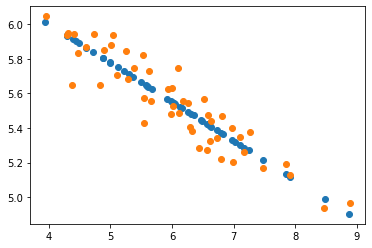

In [490]:
reconDRO, A, Z, b = DRO(data, 1)
rec_errDRO = (np.sum(np.square(data-reconDRO)))/samples
plt.scatter(reconDRO[:, 0], reconDRO[:, 1])
plt.scatter(data[:, 0], data[:, 1])
plt.show
print("DRO reconstruction error :", rec_errDRO)



NOTE: I wasn't able to get the correct results for DRLV, I am pretty sure I am calculating the updated A in each step correctly, but I may have improperly derived $/eta$, which creates the error below

DRLV reconstruction error : 1.3235740180785844


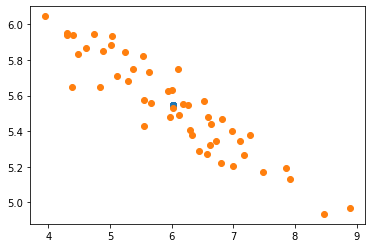

In [491]:
reconDRLV = DRLV(data, 1)
rec_errDRLV = (np.sum(np.square(data-reconDRLV)))/samples
plt.scatter(reconDRLV[:, 0], reconDRLV[:, 1])
plt.scatter(data[:, 0], data[:, 1])
plt.show
print("DRLV reconstruction error :", rec_errDRLV)

# Finding Optimal d for large dataset

In [492]:
data = np.loadtxt(open("./data/data1000D.csv", "rb"), delimiter=",") #skiprows=1)

#data = np.loadtxt(open("./data/data2D.csv", "rb"), delimiter=",") #skiprows=1)
#data = np.array([[7.269, 5.376], [4.306, 5.949],[5.038, 5.937],[7.473, 5.168],[6.295, 5.405],
#                 [5.635, 5.731],[5.554, 5.573],[4.837, 5.648],[6.178, 5.553],[5.25,  5.846]])
errB = []
errD = []
errN = []
dimensions = []
samples,features = data.shape
print(data.shape)

for i in range(50,1050,50):
    dimensions.append(i)
    z, Vd, reconB = buggyPCA(data, i)
    rec_errB = (np.sum(np.square(data-reconB)))/samples
    errB.append(rec_errB)

    z, Vd, mean, reconD = deMeanedPCA(data,i)
    rec_errD = (np.sum(np.square(data-reconD)))/samples
    errD.append(rec_errD)

    z, Vd, mean, std, reconN = normalizedPCA(data, i)
    rec_errN = (np.sum(np.square(data-reconN)))/samples
    errN.append(rec_errN)

(500, 1000)


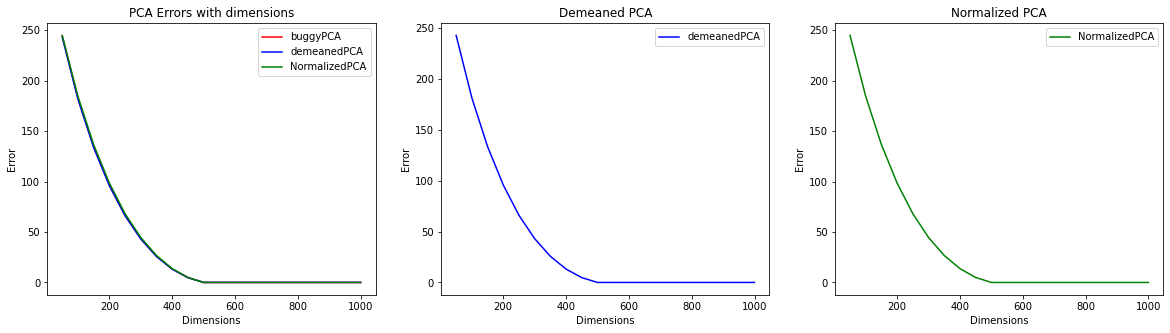

In [493]:
plt.subplots(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(dimensions, errB, c="red", label="buggyPCA")
plt.plot(dimensions, errD, c="blue", label="demeanedPCA")
plt.plot(dimensions, errN, c="green", label="NormalizedPCA")
plt.title('PCA Errors with dimensions')
plt.ylabel('Error')
plt.xlabel('Dimensions')
plt.legend(loc="upper right")

plt.subplot(1, 3, 2)
plt.plot(dimensions, errD, c="blue", label="demeanedPCA")
plt.title('Demeaned PCA')
plt.ylabel('Error')
plt.xlabel('Dimensions')
plt.legend(loc="upper right")

plt.subplot(1, 3, 3)
plt.plot(dimensions, errN, c="green", label="NormalizedPCA")
plt.title('Normalized PCA')
plt.ylabel('Error')
plt.xlabel('Dimensions')
plt.legend(loc="upper right")

plt.show()

We should use d = 500 as the error dtrastically increases for anything less as shown by the graphs above